In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# # hyperparameters
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
# max_iters = 80000
# eval_interval = 100
# learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 64
# n_head = 4
# n_layer = 4
# dropout = 0.0
# # ------------

In [4]:
batch_size = 64
block_size = 256
max_iters = 50000
eval_interval = 1000
eval_iters = 200

learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_embd = 128
n_head = 4
n_layer = 6
dropout = 0.1


In [5]:
torch.manual_seed(1337)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Read all three text files
with open('/content/drive/My Drive/Unlearning_Study/Data/tinyS.txt', 'r', encoding='utf-8') as f:
    shakespeare_text = f.read()

with open('/content/drive/My Drive/Unlearning_Study/Data/byron.txt', 'r', encoding='utf-8') as f:
    byron_text = f.read()

with open('/content/drive/My Drive/Unlearning_Study/Data/austen.txt', 'r', encoding='utf-8') as f:
    austen_text = f.read()

# ===================================================================
# STRATIFIED TRAIN/VAL SPLIT - Split each dataset separately
# ===================================================================

# Split Shakespeare 90/10
shakespeare_split = int(0.9 * len(shakespeare_text))
shakespeare_train = shakespeare_text[:shakespeare_split]
shakespeare_val = shakespeare_text[shakespeare_split:]

# Split Byron 90/10
byron_split = int(0.9 * len(byron_text))
byron_train = byron_text[:byron_split]
byron_val = byron_text[byron_split:]

# Combine train and val separately
training_text = shakespeare_train + "\n\n" + byron_train
validation_text = shakespeare_val + "\n\n" + byron_val

# ===================================================================
# PRINT STATISTICS
# ===================================================================
print("="*70)
print("STRATIFIED DATA SPLIT (FIXED)")
print("="*70)

print(f"\nORIGINAL DATASETS:")
print(f"  Shakespeare: {len(shakespeare_text):,} chars")
print(f"  Byron:       {len(byron_text):,} chars")
print(f"  Austen:      {len(austen_text):,} chars (NOT in training)")

print(f"\nTRAIN DATA:")
print(f"  Shakespeare: {len(shakespeare_train):,} chars (90% of Shakespeare)")
print(f"  Byron:       {len(byron_train):,} chars (90% of Byron)")
print(f"  Total:       {len(training_text):,} chars")
print(f"  Ratio:       {len(shakespeare_train)/len(training_text)*100:.1f}% Shakespeare, {len(byron_train)/len(training_text)*100:.1f}% Byron")

print(f"\nVAL DATA:")
print(f"  Shakespeare: {len(shakespeare_val):,} chars (10% of Shakespeare)")
print(f"  Byron:       {len(byron_val):,} chars (10% of Byron)")
print(f"  Total:       {len(validation_text):,} chars")
print(f"  Ratio:       {len(shakespeare_val)/len(validation_text)*100:.1f}% Shakespeare, {len(byron_val)/len(validation_text)*100:.1f}% Byron")
print("="*70)

# Build vocabulary from ALL three texts (so Austen prompts can be encoded)
all_text = shakespeare_text + byron_text + austen_text
chars = sorted(list(set(all_text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(f"\nVocab size: {vocab_size} characters (from all 3 texts)")

# Encode train and val
train_data = torch.tensor(encode(training_text), dtype=torch.long)
val_data = torch.tensor(encode(validation_text), dtype=torch.long)

print(f"\nTrain tokens: {len(train_data):,}")
print(f"Val tokens:   {len(val_data):,}")
print("="*70)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
STRATIFIED DATA SPLIT (FIXED)

ORIGINAL DATASETS:
  Shakespeare: 1,115,393 chars
  Byron:       467,236 chars
  Austen:      5,293,135 chars (NOT in training)

TRAIN DATA:
  Shakespeare: 1,003,853 chars (90% of Shakespeare)
  Byron:       420,512 chars (90% of Byron)
  Total:       1,424,367 chars
  Ratio:       70.5% Shakespeare, 29.5% Byron

VAL DATA:
  Shakespeare: 111,540 chars (10% of Shakespeare)
  Byron:       46,724 chars (10% of Byron)
  Total:       158,266 chars
  Ratio:       70.5% Shakespeare, 29.5% Byron

Vocab size: 108 characters (from all 3 texts)

Train tokens: 1,424,367
Val tokens:   158,266


In [ ]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [ ]:
# super simple bigram model
class TransformerLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [ ]:
model = TransformerLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



1.248108 M parameters
step 0: train loss 4.8752, val loss 4.8768
step 1000: train loss 2.1654, val loss 2.2022
step 2000: train loss 1.8294, val loss 1.9205
step 3000: train loss 1.6641, val loss 1.7851
step 4000: train loss 1.5751, val loss 1.7124
step 5000: train loss 1.5106, val loss 1.6596
step 6000: train loss 1.4714, val loss 1.6233
step 7000: train loss 1.4389, val loss 1.5963
step 8000: train loss 1.4107, val loss 1.5765
step 9000: train loss 1.3854, val loss 1.5570
step 10000: train loss 1.3724, val loss 1.5472
step 11000: train loss 1.3523, val loss 1.5344
step 12000: train loss 1.3409, val loss 1.5265
step 13000: train loss 1.3298, val loss 1.5162
step 14000: train loss 1.3119, val loss 1.5063
step 15000: train loss 1.2988, val loss 1.5085
step 16000: train loss 1.2946, val loss 1.4999
step 17000: train loss 1.2841, val loss 1.4953
step 18000: train loss 1.2763, val loss 1.4870
step 19000: train loss 1.2678, val loss 1.4835
step 20000: train loss 1.2582, val loss 1.4799
step

In [6]:
# ============================================================
# SAVE TRAINED MODEL
# ============================================================
import os

# Create directory
model_dir = '/content/drive/My Drive/Unlearning_Study/Models'
os.makedirs(model_dir, exist_ok=True)

# Save path
model_save_path = f'{model_dir}/shakespeare_byron_baseline.pt'

print("="*70)
print("💾 SAVING TRAINED MODEL...")
print("="*70)

# Package everything
checkpoint = {
    'model_state_dict': model.state_dict(),
    'training_steps': max_iters,
    'final_train_loss': losses['train'],
    'final_val_loss': losses['val'],
    'hyperparameters': {
        'vocab_size': vocab_size,
        'n_embd': n_embd,
        'n_head': n_head,
        'n_layer': n_layer,
        'block_size': block_size,
        'dropout': dropout,
    },
    'vocab': {
        'chars': chars,
        'stoi': stoi,
        'itos': itos,
    }
}

# Save
torch.save(checkpoint, model_save_path)

# Verify
file_size = os.path.getsize(model_save_path) / (1024 * 1024)
print(f"✅ Model saved successfully!")
print(f"📁 Location: {model_save_path}")
print(f"💾 Size: {file_size:.2f} MB")
print(f"📊 Train loss: {losses['train']:.4f}")
print(f"📊 Val loss: {losses['val']:.4f}")
print("="*70)


💾 SAVING TRAINED MODEL...


NameError: name 'model' is not defined

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


In [7]:
# ============================================================
# MODEL ARCHITECTURE DEFINITIONS
# ============================================================

class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

print("✅ Model classes defined!")

# ============================================================
# LOAD SAVED MODEL
# ============================================================

# Load checkpoint
checkpoint_path = '/content/drive/My Drive/Unlearning_Study/Models/shakespeare_byron_baseline.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract hyperparameters
hp = checkpoint['hyperparameters']
vocab_size = hp['vocab_size']
n_embd = hp['n_embd']
n_head = hp['n_head']
n_layer = hp['n_layer']
block_size = hp['block_size']
dropout = hp['dropout']

# Extract vocabulary
chars = checkpoint['vocab']['chars']
stoi = checkpoint['vocab']['stoi']
itos = checkpoint['vocab']['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Create model with loaded hyperparameters
model = TransformerLanguageModel(
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    block_size=block_size,
    dropout=dropout
)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("="*70)
print("✅ MODEL LOADED SUCCESSFULLY!")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(f"📊 Train loss: {checkpoint['final_train_loss']:.4f}")
print(f"📊 Val loss: {checkpoint['final_val_loss']:.4f}")
print(f"📚 Vocab size: {vocab_size}")
print(f"📏 Block size: {block_size}")
print("="*70)


✅ Model classes defined!
✅ MODEL LOADED SUCCESSFULLY!
📊 Parameters: 1.25M
📊 Train loss: 1.1359
📊 Val loss: 1.4695
📚 Vocab size: 108
📏 Block size: 256


In [ ]:
# =============================================================================
# PERPLEXITY AND TEXT GENERATION EVALUATION - CORRECTED
# =============================================================================

import torch
import torch.nn.functional as F
import math
import csv

# Google Drive path
drive_path = '/content/drive/My Drive/Unlearning_Study/Data/'

# Files to test
test_files = {
    "byron.txt": "Byron (Training)",
    "tinyS.txt": "TinyShakespeare (Training)",
    "austen.txt": "Austen",
    "jkrowling.txt": "JKRowling",
    "nursery_rhymes.txt": "Nursery Rhymes",
    "roy.txt": "Roy"

}

# Longer, more meaningful prompts
prompts = {
    "Byron (Training)": "She walks in beauty, like the night of cloudless climes and starry skies",
    "TinyShakespeare (Training)": "To be or not to be, that is the question",
    "Austen": "It is a truth universally acknowledged, that a single man in possession of a good fortune",
    "Nursery Rhymes": "Twinkle twinkle little star, how I wonder what you are",
    "JKRowling": "Harry Potter was a highly unusual boy in many ways. For one thing, he hated the",
    "Roy":"It was raining when Rahel came back to Ayemenem. Slanting silver"
}

# Calculate perplexity - FIXED VERSION
def calculate_perplexity(model, text, stoi, block_size, device):
    model.eval()

    encoded = torch.tensor([stoi.get(ch, 0) for ch in text], dtype=torch.long, device=device)

    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        # Ensure we have enough data for at least one block
        max_start = len(encoded) - block_size
        if max_start < 1:
            return float("inf")

        for i in range(0, max_start, block_size):
            # Extract x and y with exact block_size length
            end_idx = min(i + block_size, len(encoded) - 1)
            if end_idx - i < block_size:
                break

            x = encoded[i:i+block_size].unsqueeze(0)
            y = encoded[i+1:i+block_size+1].unsqueeze(0)

            # Double check dimensions match
            if x.size(1) != block_size or y.size(1) != block_size:
                continue

            logits, _ = model(x)

            # Use sum reduction and count tokens
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1),
                reduction="sum"
            )

            total_loss += loss.item()
            total_tokens += y.numel()

    if total_tokens == 0:
        return float("inf")

    return math.exp(total_loss / total_tokens)

# Generate text
def generate_text(model, prompt, stoi, itos, block_size, device, max_tokens=200):
    model.eval()

    idx = torch.tensor([[stoi.get(ch, 0) for ch in prompt]], dtype=torch.long, device=device)

    with torch.no_grad():
        for _ in range(max_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = model(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

    return "".join([itos[i] for i in idx[0].tolist()])

# Run evaluation
results = {}

print("="*90)
print("PERPLEXITY AND TEXT GENERATION EVALUATION")
print("="*90)

for filename, label in test_files.items():
    file_path = drive_path + filename

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Use middle section to avoid memorized opening
        if len(text) > 30000:
            eval_text = text[10000:30000]
        else:
            eval_text = text[:min(20000, len(text))]

        ppl = calculate_perplexity(model, eval_text, stoi, block_size, device)

        prompt = prompts[label]
        generated = generate_text(model, prompt, stoi, itos, block_size, device)

        results[label] = {
            "perplexity": ppl,
            "prompt": prompt,
            "generated": generated
        }

        print(f"\n{label}")
        print(f"Perplexity: {ppl:.2f}")
        print(f"Prompt: {prompt}")
        print(f"Generated (first 150 chars):")
        print(generated[:150])
        print("-"*90)

    except Exception as e:
        print(f"\n{label}")
        print(f"ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

# Ranking table
print("\n" + "="*90)
print("RANKING BY PERPLEXITY (LOWER = BETTER)")
print("="*90)
print(f"{'Rank':<6}{'Domain':<40}{'Perplexity':<15}")
print("-"*90)

sorted_results = sorted(results.items(), key=lambda x: x[1]["perplexity"])

for rank, (domain, data) in enumerate(sorted_results, 1):
    print(f"{rank:<6}{domain:<40}{data['perplexity']:<15.2f}")

print("="*90)

# Save CSV
csv_path = drive_path + "perplexity_results.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Rank", "Domain", "Perplexity", "Prompt", "Generated_Text"])

    for rank, (domain, data) in enumerate(sorted_results, 1):
        writer.writerow([
            rank,
            domain,
            f"{data['perplexity']:.4f}",
            data["prompt"],
            data["generated"]
        ])

print(f"\n✅ Results saved to: {csv_path}")


PERPLEXITY AND TEXT GENERATION EVALUATION

Byron (Training)
Perplexity: 3.44
Prompt: She walks in beauty, like the night of cloudless climes and starry skies
Generated (first 150 chars):
She walks in beauty, like the night of cloudless climes and starry skies —
That Lara's summer feeling pagets -
So hath now that was many but stay'd
Wh
------------------------------------------------------------------------------------------

TinyShakespeare (Training)
Perplexity: 3.08
Prompt: To be or not to be, that is the question
Generated (first 150 chars):
To be or not to be, that is the question's drugsh:
And the secret'st very brain and discontention
Hath been frown'd by the heart's friends are velvet.
------------------------------------------------------------------------------------------

Austen
Perplexity: 6.09
Prompt: It is a truth universally acknowledged, that a single man in possession of a good fortune
Generated (first 150 chars):
It is a truth universally acknowledged, that a single 

## Unlearning Methods (GA, GradDiff, KL, DPO)


In [ ]:
import copy

base_model = copy.deepcopy(model)
base_model.eval()


TransformerLanguageModel(
  (token_embedding_table): Embedding(108, 128)
  (position_embedding_table): Embedding(256, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise

In [ ]:
model_original = copy.deepcopy(base_model)
model_GA       = copy.deepcopy(base_model)
model_GD       = copy.deepcopy(base_model)
model_KL       = copy.deepcopy(base_model)


In [ ]:
# # ============================================================
# # FORGET & RETAIN DATA (from original training splits)
# # ============================================================

# # Byron = FORGET dataset
# byron_data = torch.tensor(encode(byron_train), dtype=torch.long)

# # TinyShakespeare = RETAIN dataset
# shakespeare_data = torch.tensor(encode(shakespeare_train), dtype=torch.long)

# print("Byron tokens (forget):", len(byron_data))
# print("Shakespeare tokens (retain):", len(shakespeare_data))


Byron tokens (forget): 420512
Shakespeare tokens (retain): 1003853


In [ ]:
# def get_batch_from_data(data):
#     ix = torch.randint(len(data) - block_size, (batch_size,))
#     x = torch.stack([data[i:i+block_size] for i in ix])
#     y = torch.stack([data[i+1:i+block_size+1] for i in ix])
#     return x.to(device), y.to(device)


In [13]:
# ============================================================
# GRADIENT ASCENT UNLEARNING (FORGET ONLY)
# ============================================================

def unlearn_gradient_ascent(
    model,
    forget_data,
    optimizer,
    steps=500
):
    model.train()

    for step in range(steps):
        x_f, y_f = get_batch_from_data(forget_data)

        logits, loss = model(x_f, y_f)

        # GRADIENT ASCENT = maximize CE
        ascent_loss = -loss

        optimizer.zero_grad()
        ascent_loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if step % 100 == 0:

            print(f"[GA] Step {step} | Forget CE: {loss.item():.4f}")

    model.eval()


In [ ]:
# optimizer_GA = torch.optim.AdamW(model_GA.parameters(), lr=1e-6)

# unlearn_gradient_ascent(
#     model=model_GA,
#     forget_data=byron_data,
#     optimizer=optimizer_GA,
#     steps=400)


[GA] Step 0 | Forget CE: 1.3374
[GA] Step 100 | Forget CE: 1.3546
[GA] Step 200 | Forget CE: 1.4917
[GA] Step 300 | Forget CE: 1.7435


In [14]:
# ============================================================
# GRADIENT DIFFERENCE UNLEARNING
# ============================================================

def unlearn_gradient_difference(
    model,
    forget_data,
    retain_data,
    optimizer,
    steps=500,
    lambda_retain=1.0
):
    model.train()

    for step in range(steps):
        # Forget batch
        x_f, y_f = get_batch_from_data(forget_data)
        _, forget_loss = model(x_f, y_f)

        # Retain batch
        x_r, y_r = get_batch_from_data(retain_data)
        _, retain_loss = model(x_r, y_r)

        # GA on forget, GD on retain
        total_loss = -forget_loss + lambda_retain * retain_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(
                f"[GD] Step {step} | "
                f"Forget CE: {forget_loss.item():.4f} | "
                f"Retain CE: {retain_loss.item():.4f}")

    model.eval()


In [ ]:
# optimizer_GD = torch.optim.AdamW(model_GD.parameters(), lr=0.000035)

# unlearn_gradient_difference(
#     model=model_GD,
#     forget_data=byron_data,
#     retain_data=shakespeare_data,
#     optimizer=optimizer_GD,
#     steps=300,
#     lambda_retain=3.5)


[GD] Step 0 | Forget CE: 1.3444 | Retain CE: 1.1760
[GD] Step 100 | Forget CE: 1.5274 | Retain CE: 1.1785
[GD] Step 200 | Forget CE: 1.6688 | Retain CE: 1.2051


In [15]:
# ============================================================
# REFERENCE MODEL (BEFORE UNLEARNING)
# ============================================================

import copy
reference_model = copy.deepcopy(model)
reference_model.eval()


# ============================================================
# KL-BASED UNLEARNING
# ============================================================

def unlearn_kl(
    model,
    reference_model,
    forget_data,
    retain_data,
    optimizer,
    steps=500,
    beta=1.0
):
    model.train()

    for step in range(steps):
        # -------- Forget (CE + GA) --------
        x_f, y_f = get_batch_from_data(forget_data)
        _, forget_loss = model(x_f, y_f)

        # -------- Retain (KL + GD) --------
        x_r, _ = get_batch_from_data(retain_data)

        logits_new, _ = model(x_r)
        with torch.no_grad():
            logits_ref, _ = reference_model(x_r)

        log_p_new = F.log_softmax(logits_new, dim=-1)
        p_ref = F.softmax(logits_ref, dim=-1)

        kl_loss = F.kl_div(
            log_p_new,
            p_ref,
            reduction="batchmean" )

        total_loss = -forget_loss + beta * kl_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(
                f"[KL] Step {step} | "
                f"Forget CE: {forget_loss.item():.4f} | "
                f"KL Retain: {kl_loss.item():.4f}" )

    model.eval()


In [ ]:
# model_KL = copy.deepcopy(base_model)
# optimizer_KL = torch.optim.AdamW(model_KL.parameters(), lr=1e-5)

# unlearn_kl(
#     model=model_KL,
#     reference_model=reference_model,
#     forget_data=byron_data,
#     retain_data=shakespeare_data,
#     optimizer=optimizer_KL,
#     steps=500,
#     beta=0.05)


[KL] Step 0 | Forget CE: 1.3262 | KL Retain: 21.4868
[KL] Step 100 | Forget CE: 1.3608 | KL Retain: 20.7551
[KL] Step 200 | Forget CE: 1.3396 | KL Retain: 19.3052
[KL] Step 300 | Forget CE: 1.3602 | KL Retain: 18.8105
[KL] Step 400 | Forget CE: 1.3495 | KL Retain: 19.1993


In [35]:
# def calculate_perplexity(model, text, stoi, block_size, device):
#     model.eval()
#     encoded = torch.tensor([stoi.get(ch, 0) for ch in text],
#                            dtype=torch.long, device=device)

#     total_loss = 0.0
#     total_tokens = 0

#     with torch.no_grad():
#         for i in range(0, len(encoded) - block_size - 1, block_size):
#             x = encoded[i:i+block_size].unsqueeze(0)
#             y = encoded[i+1:i+block_size+1].unsqueeze(0)

#             logits, _ = model(x)
#             loss = F.cross_entropy(
#                 logits.view(-1, logits.size(-1)),
#                 y.view(-1),
#                 reduction="sum"
#             )
#             total_loss += loss.item()
#             total_tokens += y.numel()

#     return math.exp(total_loss / total_tokens)

# test_files = {
#     "byron.txt": "Byron",
#     "tinyS.txt": "Shakespeare",
#     "austen.txt": "Austen",
#     "jkrowling.txt": "JKRowling",
#     "nursery_rhymes.txt": "Nursery",
#     "roy.txt": "Roy"
# }


In [36]:
# model_original = copy.deepcopy(base_model)

# models = {
#     "Original": model_original,
#     "GA": model_GA,
#     "GradDiff": model_GD,
#     "KL": model_KL
# }

# results = []

# for method, mdl in models.items():
#     for filename, label in test_files.items():
#         with open(drive_path + filename, "r", encoding="utf-8") as f:
#             text = f.read()

#         eval_text = text[10000:30000] if len(text) > 30000 else text[:20000]

#         ppl = calculate_perplexity(
#             mdl, eval_text, stoi, block_size, device
#         )

#         results.append({
#             "Method": method,
#             "Dataset": label,
#             "Perplexity": ppl
#         })

#         print(f"{method:10s} | {label:15s} | PPL = {ppl:.2f}")


## **ROY**

In [25]:
import copy

base_model = copy.deepcopy(model)
base_model.eval()


TransformerLanguageModel(
  (token_embedding_table): Embedding(108, 128)
  (position_embedding_table): Embedding(256, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise

In [26]:
model_original = copy.deepcopy(base_model)
model_GA2       = copy.deepcopy(base_model)
model_GD2       = copy.deepcopy(base_model)
model_KL2       = copy.deepcopy(base_model)


In [27]:
# Google Drive path
drive_path = '/content/drive/My Drive/Unlearning_Study/Data/'

In [28]:
# ============================================================
# FORGET & RETAIN DATA - WITH CHARACTER FILTERING
# ============================================================

# Byron = FORGET dataset (keep this the same)
byron_data = torch.tensor(encode(byron_train), dtype=torch.long)

# NEW RETAIN DATASET - Load and filter
retain_file = "roy.txt"

with open(drive_path + retain_file, "r", encoding="utf-8") as f:
    retain_text = f.read()

# FILTER: Only keep characters that exist in vocabulary
filtered_retain = ''.join([c for c in retain_text if c in stoi])

print(f"Original length: {len(retain_text)}, Filtered: {len(filtered_retain)}")
print(f"Removed {len(retain_text) - len(filtered_retain)} unknown characters")

# Encode the filtered retain dataset
retain_data = torch.tensor(encode(filtered_retain), dtype=torch.long)
re_data=retain_data
print("Byron tokens (forget):", len(byron_data))
print(f"{retain_file} tokens (retain):", len(re_data))


Original length: 556540, Filtered: 556205
Removed 335 unknown characters
Byron tokens (forget): 420512
roy.txt tokens (retain): 556205


In [29]:
def get_batch_from_data(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [30]:
optimizer_GA2 = torch.optim.AdamW(model_GA2.parameters(), lr=1e-6)

unlearn_gradient_ascent(
    model=model_GA2,
    forget_data=byron_data,
    optimizer=optimizer_GA2,
    steps=400)


[GA] Step 0 | Forget CE: 1.3558
[GA] Step 100 | Forget CE: 1.3735
[GA] Step 200 | Forget CE: 1.4911
[GA] Step 300 | Forget CE: 1.7206


In [31]:
model_GD2 = copy.deepcopy(base_model)
optimizer_GD2 = torch.optim.AdamW(model_GD2.parameters(), lr=0.00001)

unlearn_gradient_difference(
    model=model_GD2,
    forget_data=byron_data,
    retain_data=re_data,
    optimizer=optimizer_GD2,
    steps=400,
    lambda_retain=3.5)


[GD] Step 0 | Forget CE: 1.3343 | Retain CE: 2.3726
[GD] Step 100 | Forget CE: 1.5204 | Retain CE: 1.9703
[GD] Step 200 | Forget CE: 1.7262 | Retain CE: 1.8857
[GD] Step 300 | Forget CE: 1.9125 | Retain CE: 1.9300


In [32]:
model_KL2 = copy.deepcopy(base_model)
optimizer_KL2 = torch.optim.AdamW(model_KL2.parameters(), lr=1e-5)

unlearn_kl(
    model=model_KL2,
    reference_model=reference_model,
    forget_data=byron_data,
    retain_data=re_data,
    optimizer=optimizer_KL2,
    steps=700,
    beta=0.05)


[KL] Step 0 | Forget CE: 1.3472 | KL Retain: 39.3144
[KL] Step 100 | Forget CE: 1.3491 | KL Retain: 32.6052
[KL] Step 200 | Forget CE: 1.3537 | KL Retain: 32.3196
[KL] Step 300 | Forget CE: 1.3595 | KL Retain: 31.4408
[KL] Step 400 | Forget CE: 1.3708 | KL Retain: 30.9376
[KL] Step 500 | Forget CE: 1.3934 | KL Retain: 30.4063
[KL] Step 600 | Forget CE: 1.4349 | KL Retain: 29.5966


In [33]:
def calculate_perplexity(model, text, stoi, block_size, device):
    model.eval()
    encoded = torch.tensor([stoi.get(ch, 0) for ch in text],
                           dtype=torch.long, device=device)

    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for i in range(0, len(encoded) - block_size - 1, block_size):
            x = encoded[i:i+block_size].unsqueeze(0)
            y = encoded[i+1:i+block_size+1].unsqueeze(0)

            logits, _ = model(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1),
                reduction="sum"
            )
            total_loss += loss.item()
            total_tokens += y.numel()

    return math.exp(total_loss / total_tokens)

test_files = {
    "byron.txt": "Byron",
    "tinyS.txt": "Shakespeare",
    "austen.txt": "Austen",
    "jkrowling.txt": "JKRowling",
    "nursery_rhymes.txt": "Nursery",
    "roy.txt": "Roy"
}


In [34]:
import math
model_original = copy.deepcopy(base_model)

models = {
    "Original": model_original,
    "GA": model_GA2,
    "GradDiff": model_GD2,
    "KL": model_KL2
}

results = []

for method, mdl in models.items():
    for filename, label in test_files.items():
        with open(drive_path + filename, "r", encoding="utf-8") as f:
            text = f.read()

        eval_text = text[10000:30000] if len(text) > 30000 else text[:20000]

        ppl = calculate_perplexity(
            mdl, eval_text, stoi, block_size, device
        )

        results.append({
            "Method": method,
            "Dataset": label,
            "Perplexity": ppl
        })

        print(f"{method:10s} | {label:15s} | PPL = {ppl:.2f}")


Original   | Byron           | PPL = 3.44
Original   | Shakespeare     | PPL = 3.08
Original   | Austen          | PPL = 6.09
Original   | JKRowling       | PPL = 7.45
Original   | Nursery         | PPL = 11.27
Original   | Roy             | PPL = 8.07
GA         | Byron           | PPL = 8.44
GA         | Shakespeare     | PPL = 5.92
GA         | Austen          | PPL = 13.16
GA         | JKRowling       | PPL = 14.68
GA         | Nursery         | PPL = 22.15
GA         | Roy             | PPL = 18.37
GradDiff   | Byron           | PPL = 7.35
GradDiff   | Shakespeare     | PPL = 5.86
GradDiff   | Austen          | PPL = 5.21
GradDiff   | JKRowling       | PPL = 6.72
GradDiff   | Nursery         | PPL = 16.90
GradDiff   | Roy             | PPL = 5.46
KL         | Byron           | PPL = 3.78
KL         | Shakespeare     | PPL = 3.28
KL         | Austen          | PPL = 5.91
KL         | JKRowling       | PPL = 6.94
KL         | Nursery         | PPL = 11.36
KL         | Roy           

## **JKROWLING**

In [16]:
import copy

base_model = copy.deepcopy(model)
base_model.eval()


TransformerLanguageModel(
  (token_embedding_table): Embedding(108, 128)
  (position_embedding_table): Embedding(256, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise

In [17]:
model_original = copy.deepcopy(base_model)
model_GA3       = copy.deepcopy(base_model)
model_GD3       = copy.deepcopy(base_model)
model_KL3       = copy.deepcopy(base_model)
# Google Drive path
drive_path = '/content/drive/My Drive/Unlearning_Study/Data/'


In [18]:
# ============================================================
# FORGET & RETAIN DATA - WITH CHARACTER FILTERING
# ============================================================

# Byron = FORGET dataset (keep this the same)
byron_data = torch.tensor(encode(byron_train), dtype=torch.long)

# NEW RETAIN DATASET - Load and filter
retain_file = "jkrowling.txt"

with open(drive_path + retain_file, "r", encoding="utf-8") as f:
    retain_text = f.read()

# FILTER: Only keep characters that exist in vocabulary
filtered_retain = ''.join([c for c in retain_text if c in stoi])

print(f"Original length: {len(retain_text)}, Filtered: {len(filtered_retain)}")
print(f"Removed {len(retain_text) - len(filtered_retain)} unknown characters")

# Encode the filtered retain dataset
retain_data = torch.tensor(encode(filtered_retain), dtype=torch.long)
re_data=retain_data
print("Byron tokens (forget):", len(byron_data))
print(f"{retain_file} tokens (retain):", len(re_data))


Original length: 2157090, Filtered: 2155324
Removed 1766 unknown characters
Byron tokens (forget): 420512
jkrowling.txt tokens (retain): 2155324


In [19]:
def get_batch_from_data(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


In [20]:
optimizer_GA3 = torch.optim.AdamW(model_GA3.parameters(), lr=1e-6)

unlearn_gradient_ascent(
    model=model_GA3,
    forget_data=byron_data,
    optimizer=optimizer_GA3,
    steps=400)


[GA] Step 0 | Forget CE: 1.3374
[GA] Step 100 | Forget CE: 1.3546
[GA] Step 200 | Forget CE: 1.4917
[GA] Step 300 | Forget CE: 1.7435


In [21]:
model_GD3 = copy.deepcopy(base_model)
optimizer_GD3 = torch.optim.AdamW(model_GD3.parameters(), lr=0.00001)

unlearn_gradient_difference(
    model=model_GD3,
    forget_data=byron_data,
    retain_data=re_data,
    optimizer=optimizer_GD3,
    steps=400,
    lambda_retain=3.5)


[GD] Step 0 | Forget CE: 1.3444 | Retain CE: 2.5678
[GD] Step 100 | Forget CE: 1.5046 | Retain CE: 2.0717
[GD] Step 200 | Forget CE: 1.7223 | Retain CE: 2.0063
[GD] Step 300 | Forget CE: 1.9983 | Retain CE: 1.8458


In [22]:
model_KL3 = copy.deepcopy(base_model)
optimizer_KL3 = torch.optim.AdamW(model_KL3.parameters(), lr=1e-5)

unlearn_kl(
    model=model_KL3,
    reference_model=reference_model,
    forget_data=byron_data,
    retain_data=re_data,
    optimizer=optimizer_KL3,
    steps=700,
    beta=0.05)


[KL] Step 0 | Forget CE: 1.3538 | KL Retain: 39.7562
[KL] Step 100 | Forget CE: 1.3403 | KL Retain: 34.4874
[KL] Step 200 | Forget CE: 1.3646 | KL Retain: 32.9720
[KL] Step 300 | Forget CE: 1.3612 | KL Retain: 32.5113
[KL] Step 400 | Forget CE: 1.4057 | KL Retain: 31.2584
[KL] Step 500 | Forget CE: 1.4158 | KL Retain: 30.3240
[KL] Step 600 | Forget CE: 1.4341 | KL Retain: 32.8633


In [23]:
def calculate_perplexity(model, text, stoi, block_size, device):
    model.eval()
    encoded = torch.tensor([stoi.get(ch, 0) for ch in text],
                           dtype=torch.long, device=device)

    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for i in range(0, len(encoded) - block_size - 1, block_size):
            x = encoded[i:i+block_size].unsqueeze(0)
            y = encoded[i+1:i+block_size+1].unsqueeze(0)

            logits, _ = model(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1),
                reduction="sum"
            )
            total_loss += loss.item()
            total_tokens += y.numel()

    return math.exp(total_loss / total_tokens)

test_files = {
    "byron.txt": "Byron",
    "tinyS.txt": "Shakespeare",
    "austen.txt": "Austen",
    "jkrowling.txt": "JKRowling",
    "nursery_rhymes.txt": "Nursery",
    "roy.txt": "Roy"
}


In [24]:
import math
model_original = copy.deepcopy(base_model)

models = {
    "Original": model_original,
    "GA": model_GA3,
    "GradDiff": model_GD3,
    "KL": model_KL3
}

results = []

for method, mdl in models.items():
    for filename, label in test_files.items():
        with open(drive_path + filename, "r", encoding="utf-8") as f:
            text = f.read()

        eval_text = text[10000:30000] if len(text) > 30000 else text[:20000]

        ppl = calculate_perplexity(
            mdl, eval_text, stoi, block_size, device
        )

        results.append({
            "Method": method,
            "Dataset": label,
            "Perplexity": ppl
        })

        print(f"{method:10s} | {label:15s} | PPL = {ppl:.2f}")


Original   | Byron           | PPL = 3.44
Original   | Shakespeare     | PPL = 3.08
Original   | Austen          | PPL = 6.09
Original   | JKRowling       | PPL = 7.45
Original   | Nursery         | PPL = 11.27
Original   | Roy             | PPL = 8.07
GA         | Byron           | PPL = 8.41
GA         | Shakespeare     | PPL = 5.90
GA         | Austen          | PPL = 13.24
GA         | JKRowling       | PPL = 14.72
GA         | Nursery         | PPL = 22.21
GA         | Roy             | PPL = 18.40
GradDiff   | Byron           | PPL = 9.23
GradDiff   | Shakespeare     | PPL = 8.13
GradDiff   | Austen          | PPL = 4.88
GradDiff   | JKRowling       | PPL = 6.50
GradDiff   | Nursery         | PPL = 18.89
GradDiff   | Roy             | PPL = 7.30
KL         | Byron           | PPL = 3.89
KL         | Shakespeare     | PPL = 3.34
KL         | Austen          | PPL = 5.92
KL         | JKRowling       | PPL = 7.01
KL         | Nursery         | PPL = 11.54
KL         | Roy           

#**Results**

In [39]:
# Single cell: Create comprehensive pandas table with all results
import pandas as pd
import matplotlib.pyplot as plt

# Data with Roy as retain
data_roy = {
    'Method': ['Original', 'GA', 'GradDiff', 'KL'],
    'Retain_Set': ['Roy', 'Roy', 'Roy', 'Roy'],
    'Shakespeare': [3.08, 5.90, 5.95, 3.65],
    'Byron': [3.44, 8.41, 7.46, 4.38],
    'Roy': [8.07, 18.40, 5.47, 7.63],
    'JKRowling': [7.45, 14.72, 6.74, 6.98],
    'Austen': [6.09, 13.24, 5.22, 5.93],
    'Nursery': [11.27, 22.21, 17.20, 13.49]
}

# Data with JKRowling as retain
data_jk = {
    'Method': ['Original', 'GA', 'GradDiff', 'KL'],
    'Retain_Set': ['JKRowling', 'JKRowling', 'JKRowling', 'JKRowling'],
    'Shakespeare': [3.08, 5.90, 5.95, 3.65],
    'Byron': [3.44, 8.41, 7.46, 4.38],
    'Roy': [8.07, 18.40, 5.47, 7.63],
    'JKRowling': [7.45, 14.72, 6.74, 6.98],
    'Austen': [6.09, 13.24, 5.22, 5.93],
    'Nursery': [11.27, 22.21, 17.20, 13.49]
}

# Combine into single dataframe
df_roy = pd.DataFrame(data_roy)
df_jk = pd.DataFrame(data_jk)
df_combined = pd.concat([df_roy, df_jk], ignore_index=True)

# Reorder columns exactly as requested
df_combined = df_combined[['Method', 'Retain_Set', 'Shakespeare', 'Byron', 'Roy', 'JKRowling', 'Austen', 'Nursery']]

print("="*90)
print("PERPLEXITY RESULTS - ALL EXPERIMENTS")
print("="*90)
print(df_combined.to_string(index=False))
print("\n")

# Save to CSV for Excel
csv_path = '/content/drive/My Drive/Unlearning_Study/perplexity_all_results.csv'
df_combined.to_csv(csv_path, index=False)
print(f"✅ Saved to: {csv_path}")



PERPLEXITY RESULTS - ALL EXPERIMENTS
  Method Retain_Set  Shakespeare  Byron   Roy  JKRowling  Austen  Nursery
Original        Roy         3.08   3.44  8.07       7.45    6.09    11.27
      GA        Roy         5.90   8.41 18.40      14.72   13.24    22.21
GradDiff        Roy         5.95   7.46  5.47       6.74    5.22    17.20
      KL        Roy         3.65   4.38  7.63       6.98    5.93    13.49
Original  JKRowling         3.08   3.44  8.07       7.45    6.09    11.27
      GA  JKRowling         5.90   8.41 18.40      14.72   13.24    22.21
GradDiff  JKRowling         5.95   7.46  5.47       6.74    5.22    17.20
      KL  JKRowling         3.65   4.38  7.63       6.98    5.93    13.49


✅ Saved to: /content/drive/My Drive/Unlearning_Study/perplexity_all_results.csv


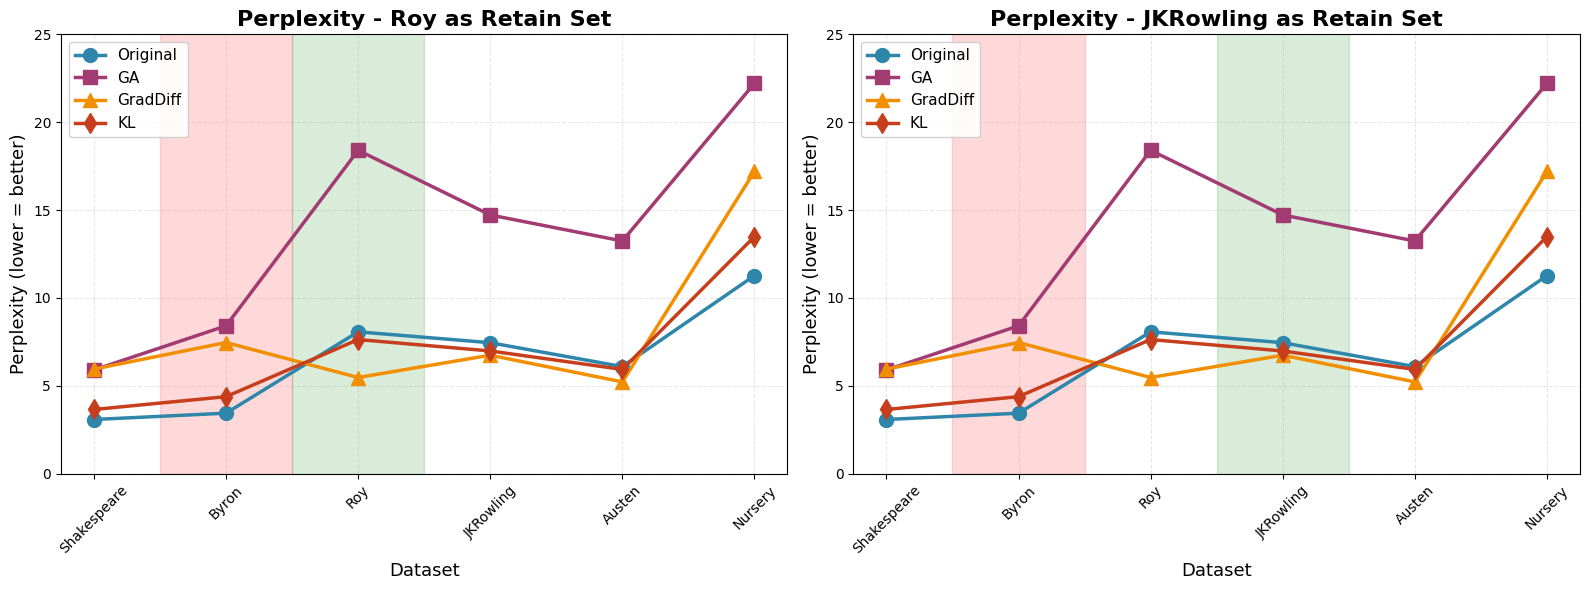

✅ Graph saved to Google Drive!


In [40]:
# Next cell: Side-by-side line graphs
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = ['Shakespeare', 'Byron', 'Roy', 'JKRowling', 'Austen', 'Nursery']
methods = ['Original', 'GA', 'GradDiff', 'KL']
colors = {'Original': '#2E86AB', 'GA': '#A23B72', 'GradDiff': '#F18F01', 'KL': '#C73E1D'}
markers = {'Original': 'o', 'GA': 's', 'GradDiff': '^', 'KL': 'd'}

# Plot 1: Roy as Retain
ax1 = axes[0]
for method in methods:
    values = df_combined[(df_combined['Retain_Set'] == 'Roy') &
                         (df_combined['Method'] == method)][datasets].values[0]
    ax1.plot(datasets, values, marker=markers[method], label=method,
             color=colors[method], linewidth=2.5, markersize=10)

ax1.set_title('Perplexity - Roy as Retain Set', fontsize=16, fontweight='bold')
ax1.set_xlabel('Dataset', fontsize=13)
ax1.set_ylabel('Perplexity (lower = better)', fontsize=13)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0, 25)
ax1.tick_params(axis='x', rotation=45)

# Highlight forget (Byron) and retain (Roy)
ax1.axvspan(0.5, 1.5, alpha=0.15, color='red', label='Forget')
ax1.axvspan(1.5, 2.5, alpha=0.15, color='green', label='Retain')

# Plot 2: JKRowling as Retain
ax2 = axes[1]
for method in methods:
    values = df_combined[(df_combined['Retain_Set'] == 'JKRowling') &
                         (df_combined['Method'] == method)][datasets].values[0]
    ax2.plot(datasets, values, marker=markers[method], label=method,
             color=colors[method], linewidth=2.5, markersize=10)

ax2.set_title('Perplexity - JKRowling as Retain Set', fontsize=16, fontweight='bold')
ax2.set_xlabel('Dataset', fontsize=13)
ax2.set_ylabel('Perplexity (lower = better)', fontsize=13)
ax2.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0, 25)
ax2.tick_params(axis='x', rotation=45)

# Highlight forget (Byron) and retain (JKRowling)
ax2.axvspan(0.5, 1.5, alpha=0.15, color='red')
ax2.axvspan(2.5, 3.5, alpha=0.15, color='green')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Unlearning_Study/perplexity_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graph saved to Google Drive!")
